### Import data

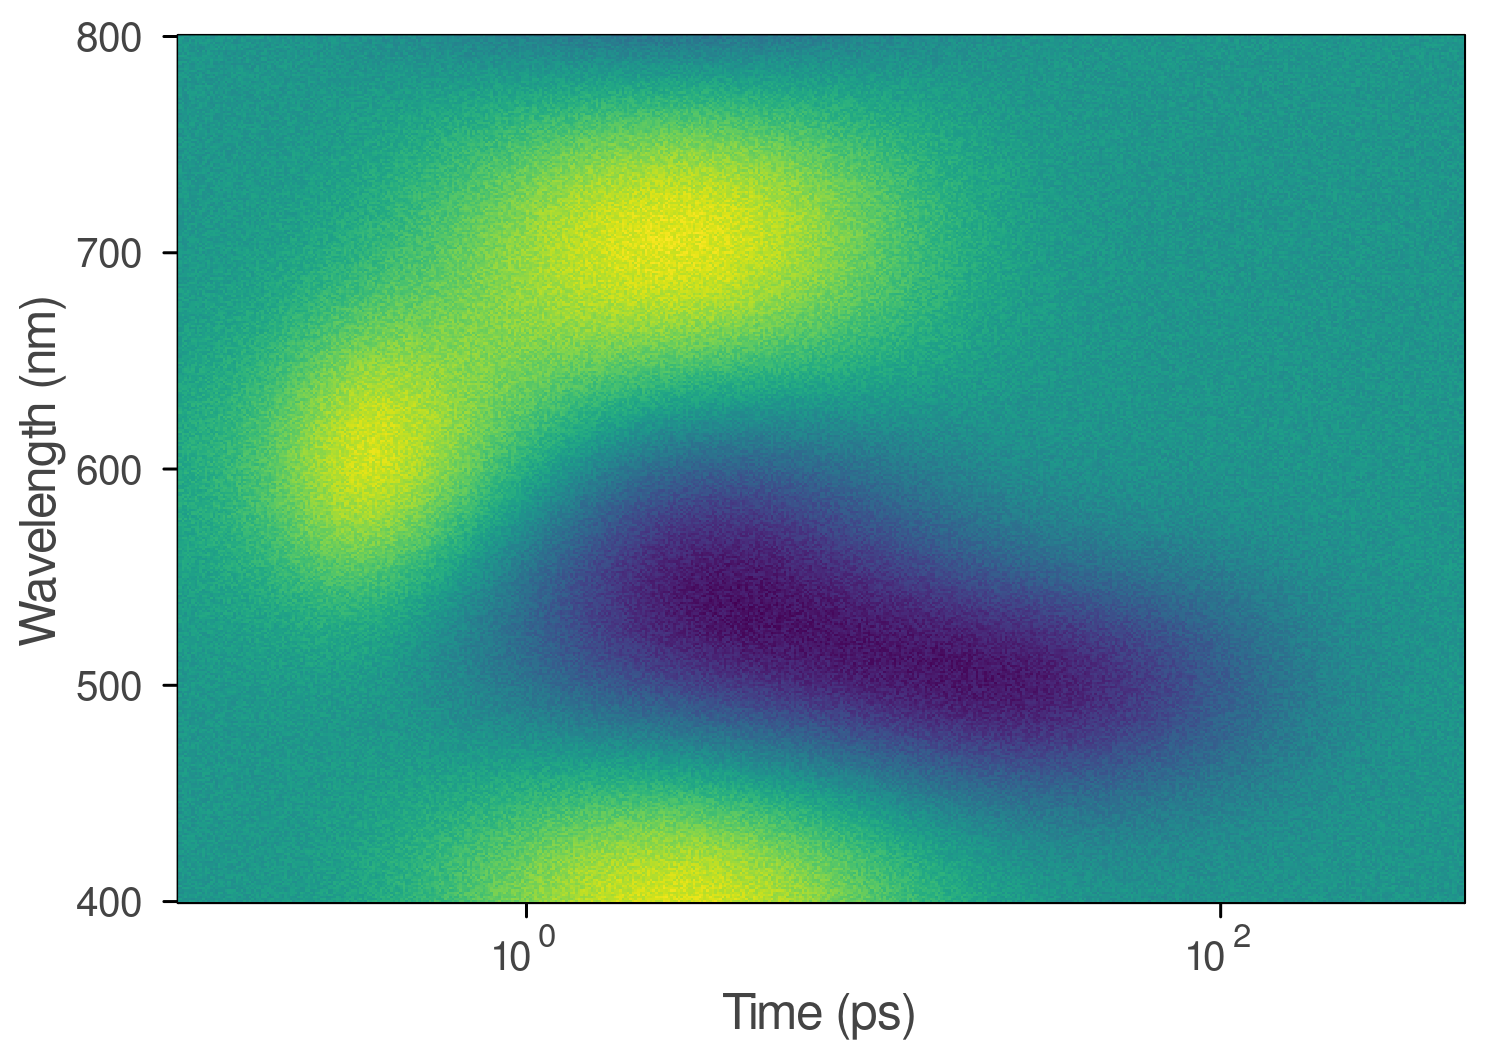

In [10]:
include("../src/import.jl")
include("../src/plots.jl")

# define .csv file containing experimental data
# file = raw"C:\Data\testdat_first_order_seq.csv"
file = joinpath("..", "data", "testData_first_order_seq.csv")

# import data
data = importData(file)[1]
# spectral dimension
s = data.x
# time dimension
t = data.y
# 2D data
d = data.z

# plot dataset for quick overview
tBl = t .> 0
heatmap(t[tBl], s, d[:,tBl], xscale=:log10, c=:viridis,
    xlabel="Time (ps)", ylabel="Wavelength (nm)")


### Define kinetic model

In [11]:
include("../src/kinetic.jl")

# define kinetic model
rn = @reaction_network begin
    k1, A --> B
    k2, B --> C
    k3, C --> 0
end

# define starting values and bounds for the parameter optimization 
limits = Dict(
    :A => 1,
    :B => 0,
    :C => 0,
    :k1 => [5e-1, 5],
    :k2 => [5e-2, 5e-1],
    :k3 => [5e-3, 5e-2],
    :μ => [-0.5, 0.5],
    :σ => [0.04, 0.2]
)

# show reaction network
using Latexify
latexify(rn)

L"\begin{align*}
\mathrm{A} &\xrightarrow{k1} \mathrm{B} \\
\mathrm{B} &\xrightarrow{k2} \mathrm{C} \\
\mathrm{C} &\xrightarrow{k3} \varnothing  
 \end{align*}
"

### Run the optimization

In [12]:
# maximum number of iterations
maxIter = 200

# generate bounds for fit parameters
bounds = generateBoundsMH(rn, limits)

# run optimization
using Metaheuristics
options = Options(iterations=maxIter, parallel_evaluation=true, store_convergence=true)
result = Metaheuristics.optimize((param)->simulateDataParallel(t, rn, param, limits, d),
    bounds, DE(N=10;options))

Optimization Result
===================
  Iteration:       200
  Minimum:         590.236
  Minimizer:       [0.997343, 0.100348, 0.0100013, …, 0.0996737]
  Function calls:  2000
  Total time:      6.1910 s
  Stop reason:     Maximum number of iterations exceeded.

### Monitor fit convergence
You can increase `maxIter` if there is no clear convergence.

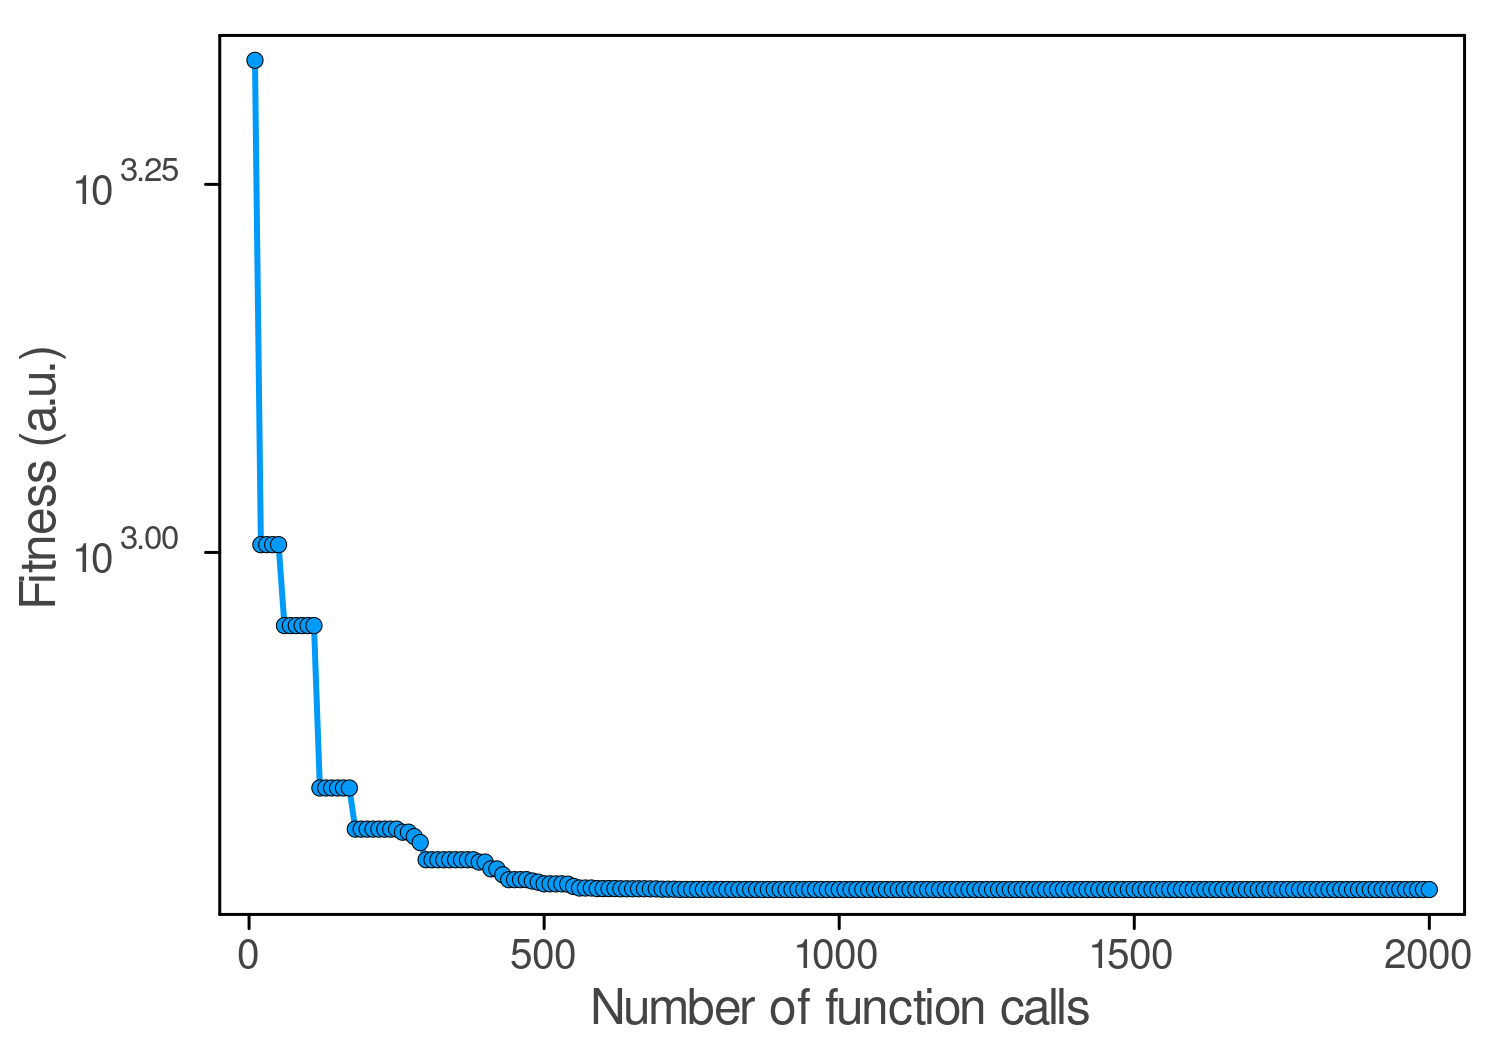

In [13]:
plot(convergence(result)..., xlabel="Number of function calls", ylabel="Fitness (a.u.)",
    marker=:circle, ms=3, msw=0.5, yscale=:log10)

### Get optimized parameters and fit data

In [14]:
# get optimized parameters
fitParam = minimizer(result)

5-element Vector{Float64}:
 0.9973429786752928
 0.10034827965186788
 0.010001260582309495
 0.1995665861641629
 0.09967374660755733

In [15]:
# get best fit data
fitData, fitSpc, fitKin = simulateData(t, rn, fitParam, limits, d; ret="kin")

([0.0 0.0 … -0.000331520806177977 -0.00030458976520155985; 0.0 0.0 … -0.00042701926867303195 -0.0003923304249924961; … ; 0.0 0.0 … -2.6817642470903966e-5 -2.463911546802543e-5; 0.0 0.0 … -3.503705637025407e-5 -3.2190826561396315e-5], [0.0018846174511469062 0.9772110672871617 -0.04054274027171032; -0.006872910800930867 0.9956523193152111 -0.05222155285038792; … ; 0.009671523802755938 -0.27487515249341016 -0.0032796153156486037; -0.005114091231294158 -0.29087421600349156 -0.004284793743961606], [0.0 0.0 0.0; 0.0 0.0 0.0; … ; 1.120393799283102e-18 -1.245734443198367e-18 0.008177069530973526; 7.730645667161956e-19 -8.595487051029564e-19 0.007512806563154142])

### Plot optimized kinetics

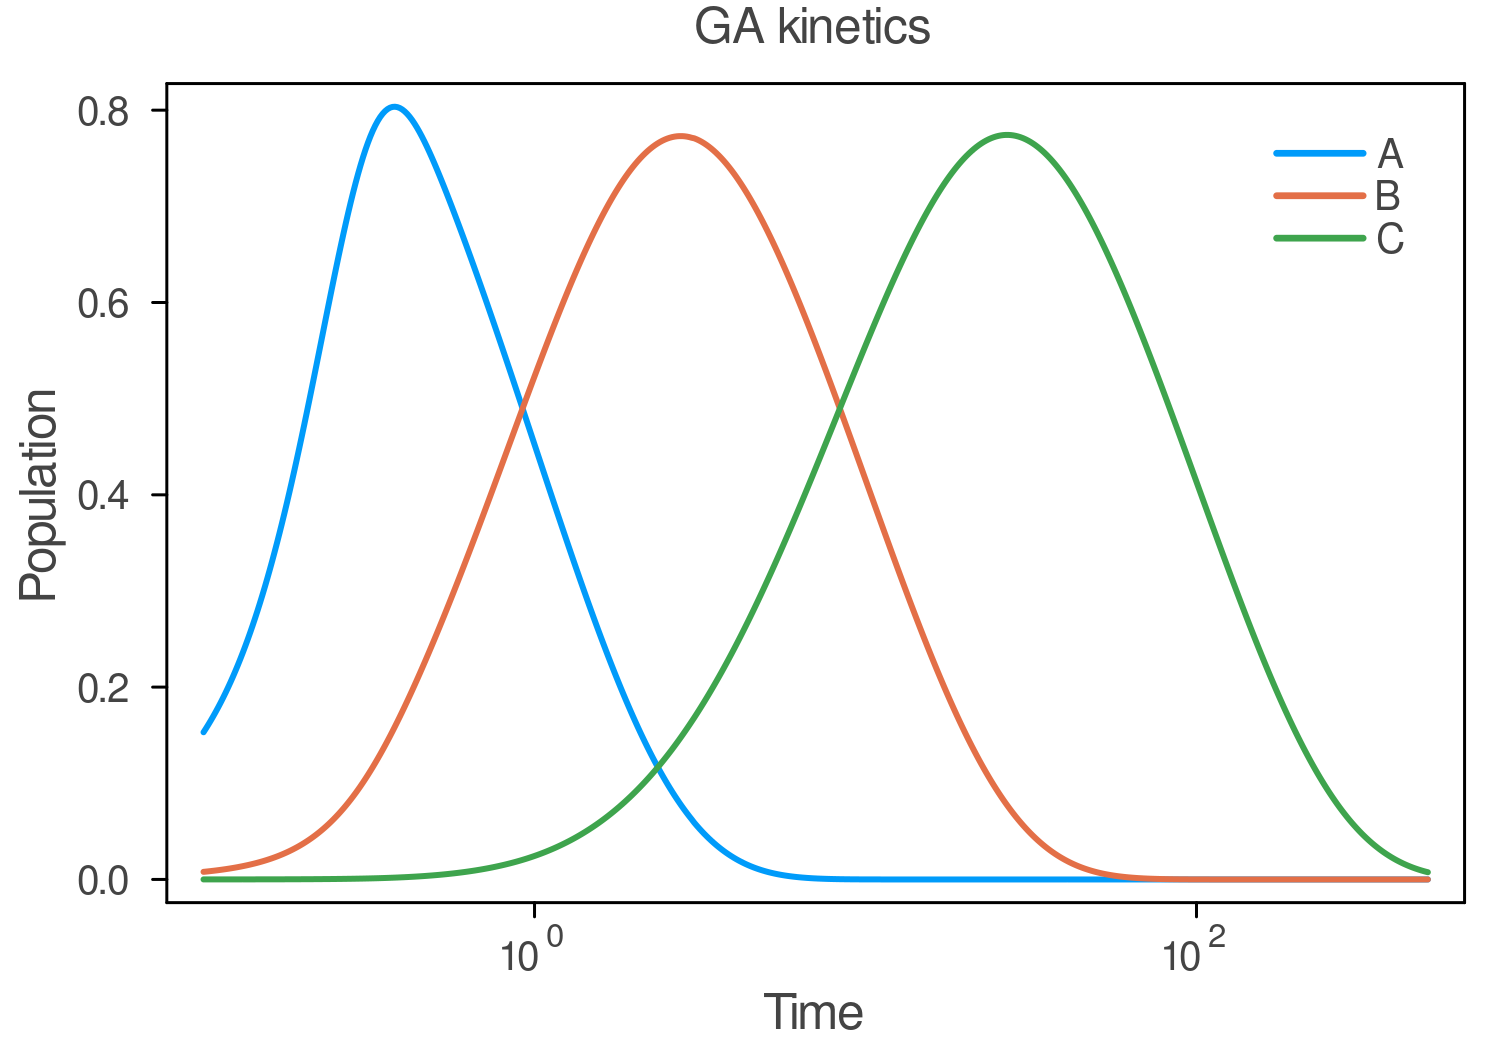

In [16]:
# positive times for log plot
tBl = t .> 0

# plot kinetics
plot(t[tBl], fitKin[tBl,:], xscale=:log10, title="GA kinetics", 
    xlabel="Time", ylabel="Population", legend=true,
    label=getLabels(rn))

### Plot optimized spectral signatures

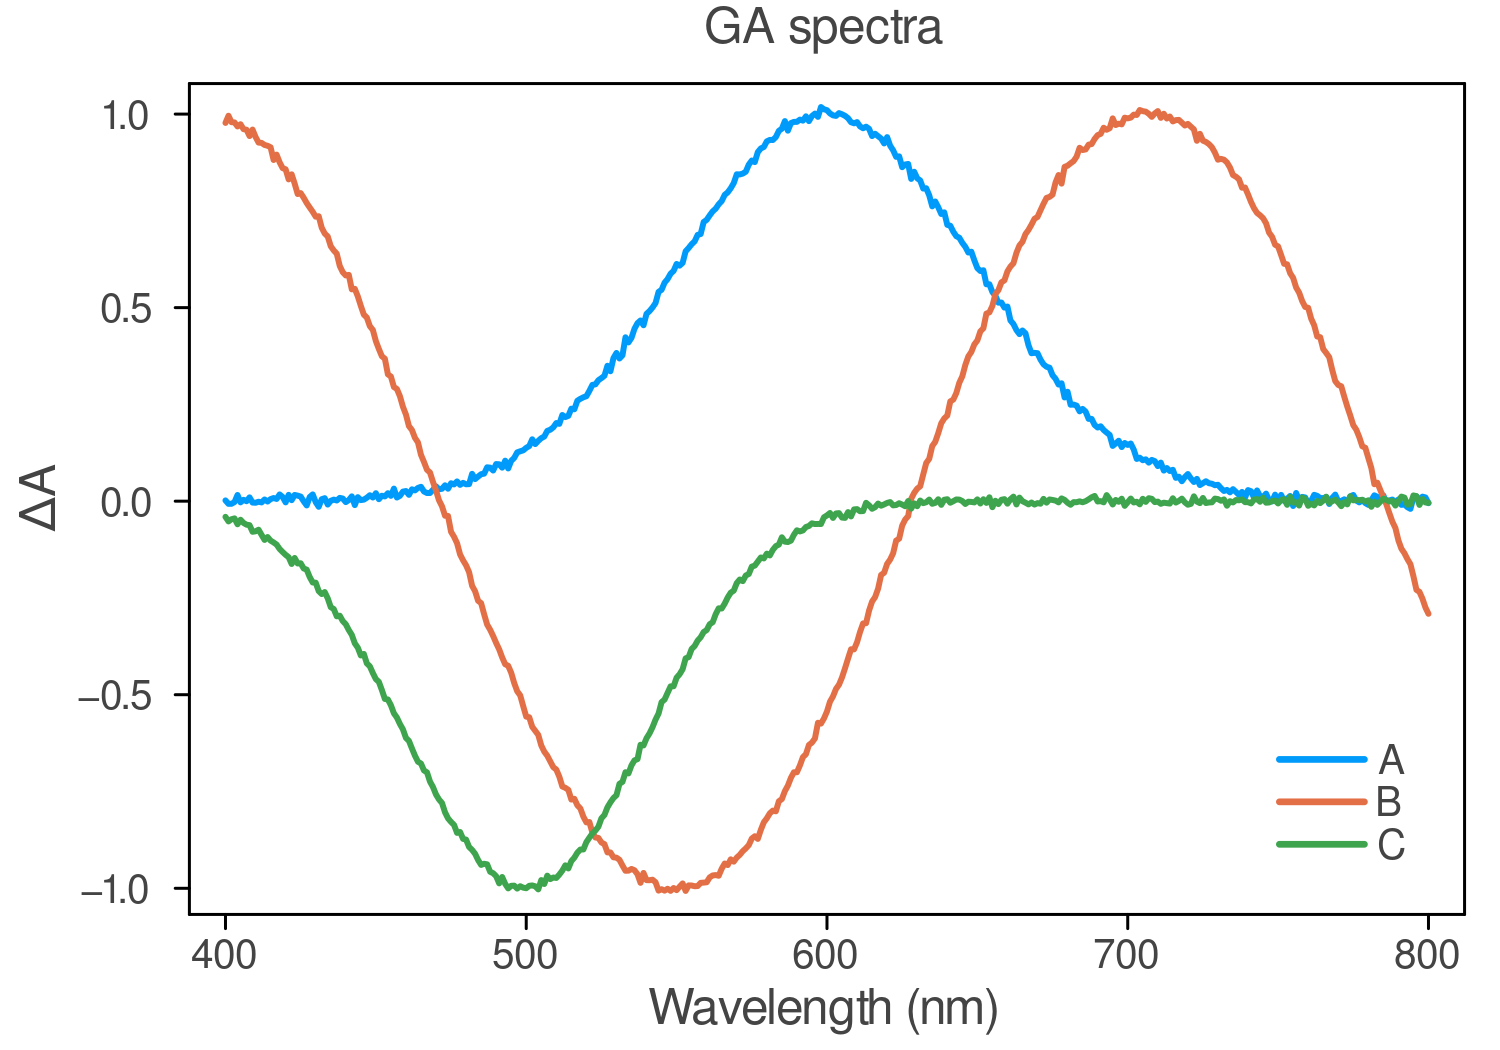

In [17]:
plot(s, fitSpc, title="GA spectra", 
xlabel="Wavelength (nm)", ylabel="ΔA", legend=true, label=getLabels(rn))

### Plot fit residuals

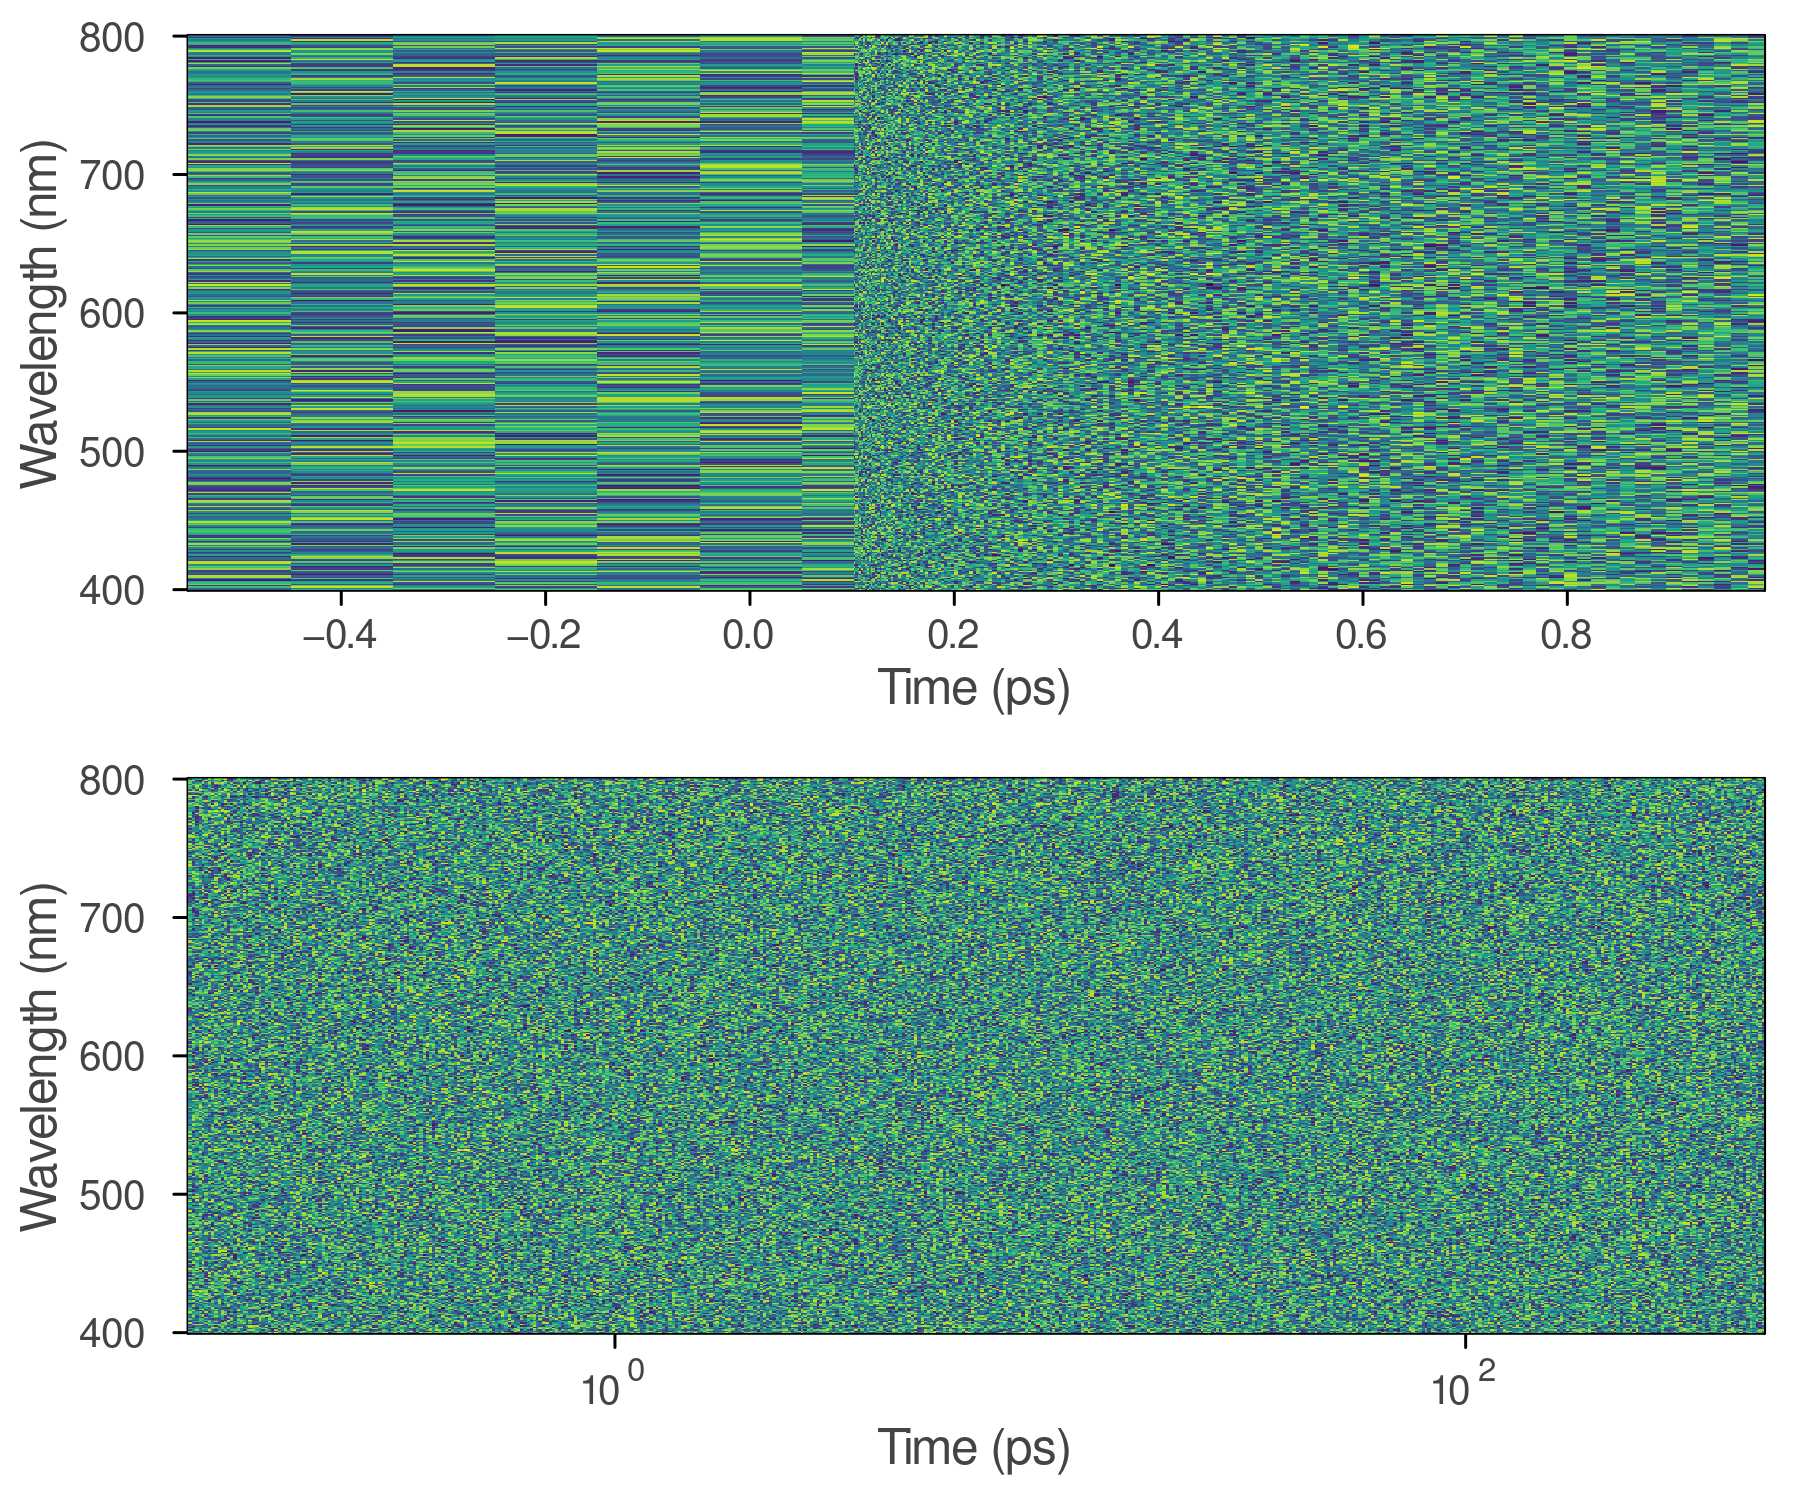

In [18]:
# linear plot around t = 0
tBl = -0.5 .≤ t .≤ 1
p1 = heatmap(t[tBl], s, d[:,tBl] .- fitData[:,tBl], c=:viridis,
    xlabel="Time (ps)", ylabel="Wavelength (nm)")

# log plot at positive times
tBl = t .> 0
p2 = heatmap(t[tBl], s, d[:,tBl] .- fitData[:,tBl], c=:viridis,
    xscale=:log10, xlabel="Time (ps)", ylabel="Wavelength (nm)")

# combine plots
plot(p1,p2, layout=(2,1), size=(600,500))